In [22]:
# Librairies

import numpy as np
import random as rd 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from shutil import copyfile
from sklearn.model_selection import train_test_split
from torch import optim
from tqdm import tqdm

In [3]:
# Répertoires
ct_dir = "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/dataset/CT/MSKCC"
seg_dir = "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/dataset/Segmentation/MSKCC"

# Lister les fichiers CT et segmentation
ct_files = sorted([f for f in os.listdir(ct_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
seg_files = sorted([f for f in os.listdir(seg_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])

# Trouver les fichiers appariés (même nom)
common_files = sorted(list(set(ct_files) & set(seg_files)))
print(f"{len(common_files)} fichiers appariés trouvés.")
print("Exemples :", common_files[:3])


200 fichiers appariés trouvés.
Exemples : ['330680.nii.gz', '330681.nii.gz', '330682.nii.gz']


Fichier sélectionné : 330680.nii.gz
Dimensions du scan : (512, 512, 130)
Dimensions du masque : (512, 512, 130)


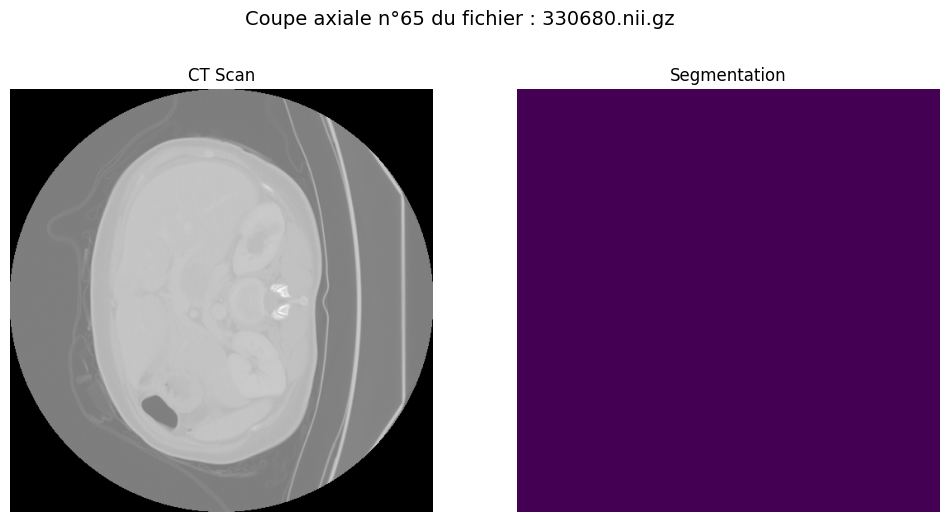

In [4]:
# Choisir un fichier
filename = common_files[0]  # Tu peux changer l'index ici
print("Fichier sélectionné :", filename)

# Charger les données
ct_path = os.path.join(ct_dir, filename)
seg_path = os.path.join(seg_dir, filename)

ct_img = nib.load(ct_path)
seg_img = nib.load(seg_path)

ct_data = ct_img.get_fdata()
seg_data = seg_img.get_fdata()

print("Dimensions du scan :", ct_data.shape)
print("Dimensions du masque :", seg_data.shape)

# 🖼️ Afficher une slice centrale
slice_index = ct_data.shape[2] // 2

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(ct_data[:, :, slice_index], cmap='gray')
axs[0].set_title('CT Scan')
axs[0].axis('off')

axs[1].imshow(seg_data[:, :, slice_index], cmap='viridis', vmin=0, vmax=2)
axs[1].set_title('Segmentation')
axs[1].axis('off')

plt.suptitle(f"Coupe axiale n°{slice_index} du fichier : {filename}", fontsize=14)
plt.show()

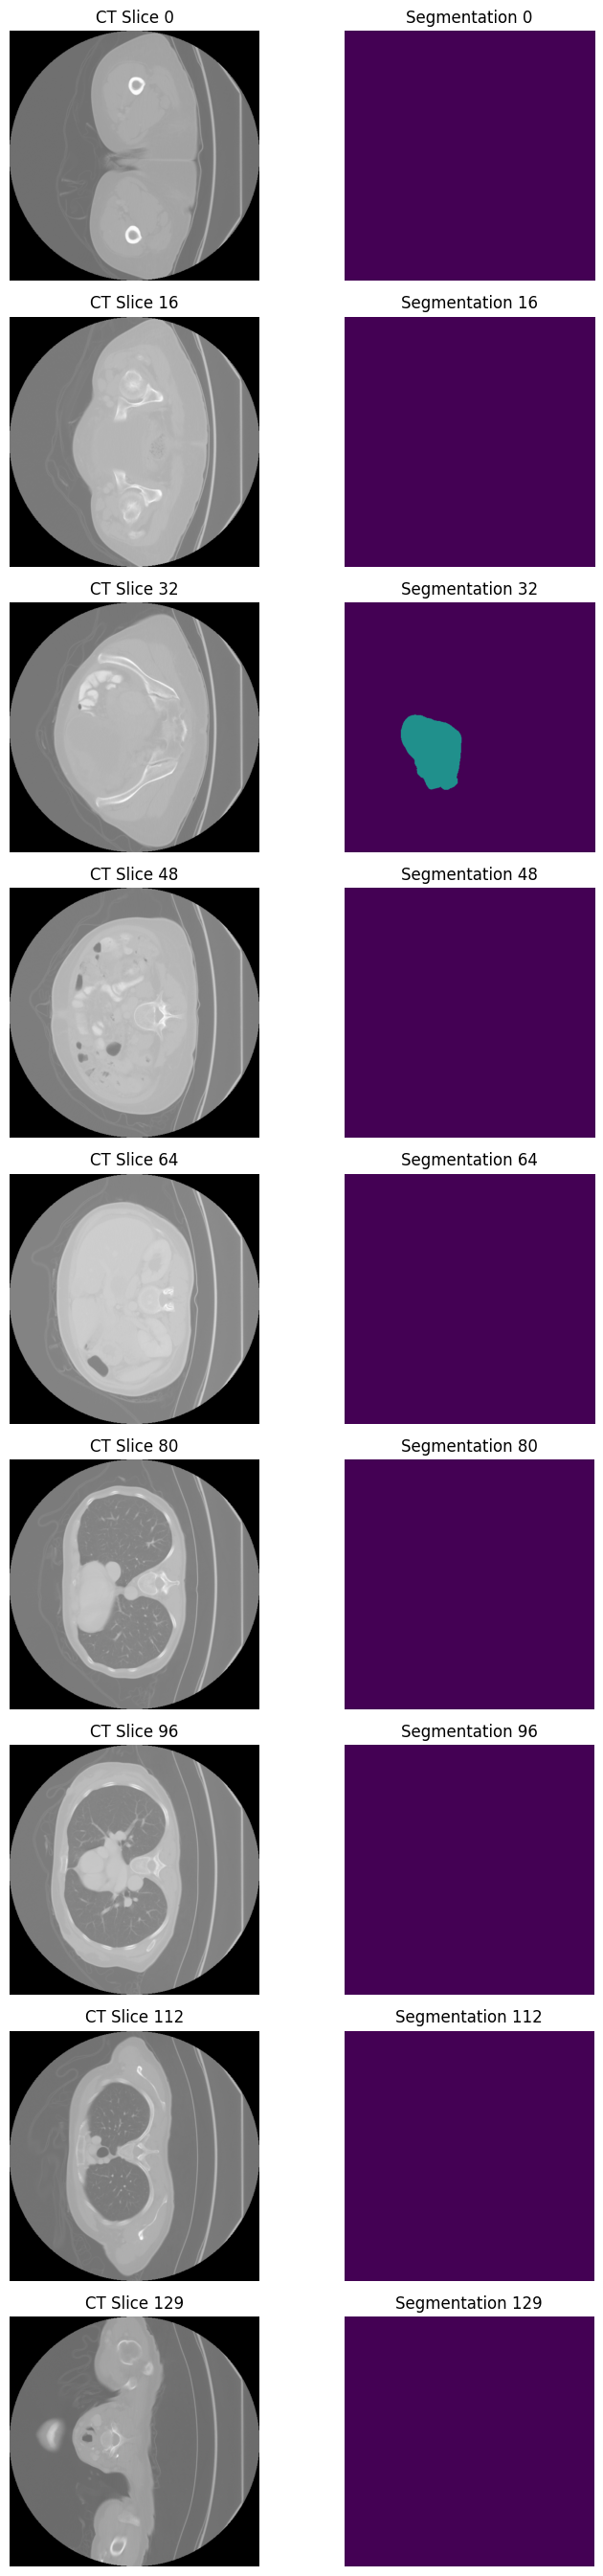

In [5]:
# 🧮 Choisir combien de slices afficher
num_slices = 9
indices = np.linspace(0, ct_data.shape[2] - 1, num_slices, dtype=int)

# 🎨 Affichage en grille 3x2 par slice (CT à gauche, segmentation à droite)
fig, axs = plt.subplots(num_slices, 2, figsize=(8, 3 * num_slices))

for i, idx in enumerate(indices):
    axs[i, 0].imshow(ct_data[:, :, idx], cmap='gray')
    axs[i, 0].set_title(f'CT Slice {idx}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(seg_data[:, :, idx], cmap='viridis', vmin=0, vmax=2)
    axs[i, 1].set_title(f'Segmentation {idx}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
base_seg =  "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/dataset/Segmentation"
centers = ["MSKCC", "TCGA"]

for center in centers:
    seg_dir = os.path.join(base_seg, center)
    seg_files = sorted([f for f in os.listdir(seg_dir) if f.endswith('.nii') or f.endswith('.nii.gz')])
    
    print(f"🔍 Analyse des segmentations dans {center} ({len(seg_files)} fichiers)")
    
    for filename in seg_files:
        seg_path = os.path.join(seg_dir, filename)
        seg_data = nib.load(seg_path).get_fdata()

        total_voxels = np.prod(seg_data.shape)
        nonzero_voxels = np.count_nonzero(seg_data)

        if nonzero_voxels == 0:
            print(f"⚠️ Aucune annotation dans {filename}")
        else:
            ratio = 100 * nonzero_voxels / total_voxels
            print(f"✅ {filename} : {nonzero_voxels} voxels annotés ({ratio:.4f} %)")

🔍 Analyse des segmentations dans MSKCC (200 fichiers)
✅ 330680.nii.gz : 216267 voxels annotés (0.6346 %)
✅ 330681.nii.gz : 46400 voxels annotés (0.1945 %)
✅ 330682.nii.gz : 172857 voxels annotés (0.7579 %)
✅ 330683.nii.gz : 93749 voxels annotés (0.2908 %)
✅ 330684.nii.gz : 1664 voxels annotés (0.0077 %)
✅ 330685.nii.gz : 4026 voxels annotés (0.0146 %)
✅ 330686.nii.gz : 30144 voxels annotés (0.1236 %)
✅ 330687.nii.gz : 18716 voxels annotés (0.0752 %)
✅ 330688.nii.gz : 120280 voxels annotés (0.3557 %)
✅ 330689.nii.gz : 263866 voxels annotés (1.0271 %)
✅ 330690.nii.gz : 81851 voxels annotés (0.2313 %)
✅ 330693.nii.gz : 24657 voxels annotés (0.0741 %)
✅ 330696.nii.gz : 54376 voxels annotés (0.2305 %)
✅ 330697.nii.gz : 92423 voxels annotés (0.2776 %)
✅ 330698.nii.gz : 45123 voxels annotés (0.1831 %)
✅ 330699.nii.gz : 34514 voxels annotés (0.1097 %)
✅ 330700.nii.gz : 72720 voxels annotés (0.3383 %)
✅ 330701.nii.gz : 189421 voxels annotés (0.8706 %)
✅ 330702.nii.gz : 19894 voxels annotés (0.0

In [7]:
"""# 📁 Répertoires d'entrée
ct_base = "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/dataset/CT"
seg_base = "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/dataset/Segmentation"
centers = ["MSKCC", "TCGA"]

# 📁 Répertoires de sortie
output_img_dir = "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/output/images"
output_mask_dir = "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/output/masks"
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

# 🔁 Traitement de chaque fichier
for center in centers:
    ct_dir = os.path.join(ct_base, center)
    seg_dir = os.path.join(seg_base, center)
    ct_files = [f for f in os.listdir(ct_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]

    for filename in ct_files:
        ct_path = os.path.join(ct_dir, filename)
        seg_path = os.path.join(seg_dir, filename)
        
        if not os.path.exists(seg_path):
            print(f"⚠️ Pas de segmentation pour {filename}")
            continue

        # Charger les volumes
        ct = nib.load(ct_path).get_fdata()
        mask = nib.load(seg_path).get_fdata()

        # Normalisation du CT (0-1 par volume)
        ct_min, ct_max = np.min(ct), np.max(ct)
        ct_norm = (ct - ct_min) / (ct_max - ct_min + 1e-8)

        # Pour chaque slice axiale
        for i in range(ct.shape[2]):
            slice_ct = ct_norm[:, :, i].astype(np.float32)
            slice_mask = mask[:, :, i].astype(np.uint8)

            # Si la slice a au moins un pixel annoté
            if np.count_nonzero(slice_mask) > 0:
                # Nom du fichier
                base_name = filename.replace(".nii.gz", "").replace(".nii", "")
                img_out = os.path.join(output_img_dir, f"{base_name}_slice_{i}.npy")
                mask_out = os.path.join(output_mask_dir, f"{base_name}_slice_{i}.npy")

                # Sauvegarde
                np.save(img_out, slice_ct)
                np.save(mask_out, slice_mask)

        print(f"✅ {filename} traité")"""

'# 📁 Répertoires d\'entrée\nct_base = "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/dataset/CT"\nseg_base = "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/dataset/Segmentation"\ncenters = ["MSKCC", "TCGA"]\n\n# 📁 Répertoires de sortie\noutput_img_dir = "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/output/images"\noutput_mask_dir = "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/output/masks"\nos.makedirs(output_img_dir, exist_ok=True)\nos.makedirs(output_mask_dir, exist_ok=True)\n\n# 🔁 Traitement de chaque fichier\nfor center in centers:\n    ct_dir = os.path.join(ct_base, center)\n    seg_dir = os.path.join(seg_base, center)\n    ct_files = [f for f in os.listdir(ct_dir) if f.endswith(".nii") or f.endswith(".nii.gz")]\n\n    for filename in ct_files:\n        ct_path = os.path.join(ct_dir, filename)\n        seg_path = os.path.join(seg_dir, filename)\n\n        if not os.path.exists(seg_path):\n            print(f"⚠️ Pas de segm

In [8]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.filenames = file_list
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.filenames[idx])

        image = np.load(img_path).astype(np.float32)
        mask = np.load(mask_path).astype(np.int64)

        image = torch.tensor(image).unsqueeze(0)  # (1, H, W)
        mask = torch.tensor(mask)

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

In [21]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, file_list, transform=None, size=256):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.filenames = file_list
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.filenames[idx])

        image = torch.tensor(np.load(img_path)).unsqueeze(0).float()  # (1, H, W)
        mask = torch.tensor(np.load(mask_path)).long()                # (H, W)

        # Redimensionnement à 256x256
        image = F.interpolate(image.unsqueeze(0), size=(self.size, self.size), mode='bilinear').squeeze(0)
        mask = F.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), size=(self.size, self.size), mode='nearest').squeeze().long()

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

In [9]:
images_path = "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/output/images"
masks_path = "/Users/alexandretranie/Desktop/Pinkcc/pinkcc-data-challenge/output/masks"
all_files = sorted([f for f in os.listdir(images_path) if f.endswith(".npy")])

# Instancier le dataset
dataset = SegmentationDataset(images_path, masks_path, all_files)

# Charger en batchs
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Exemple : affichage d'un batch
for images, masks in dataloader:
    print("Image batch shape :", images.shape)  # (B, 1, H, W)
    print("Mask batch shape  :", masks.shape)   # (B, H, W)
    break

Image batch shape : torch.Size([4, 1, 512, 512])
Mask batch shape  : torch.Size([4, 512, 512])


In [10]:
# Liste de tous les fichiers image (tu peux supposer qu'ils ont tous un masque correspondant)
all_files = sorted([f for f in os.listdir(images_path) if f.endswith(".npy")])

# Split 80/20
train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

print(f"📦 Train : {len(train_files)} slices")
print(f"🧪 Val   : {len(val_files)} slices")

📦 Train : 5177 slices
🧪 Val   : 1295 slices


In [11]:
train_dataset = SegmentationDataset(images_path, masks_path, train_files)
val_dataset = SegmentationDataset(images_path, masks_path, val_files)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [12]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        m = self.middle(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(m), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)  # shape: (B, 3, H, W)

In [13]:
model = UNet(in_channels=1, out_channels=3)
x = torch.randn(1, 1, 512, 512)  # image CT
y = model(x)
print(y.shape)  # 🔁 (1, 3, 512, 512)

torch.Size([1, 3, 512, 512])


In [14]:
# Dice score (moyenne sur toutes les classes)
def multiclass_dice_score(preds, targets, num_classes=3):
    preds = F.one_hot(preds, num_classes).permute(0, 3, 1, 2).float()  # (B, C, H, W)
    targets = F.one_hot(targets, num_classes).permute(0, 3, 1, 2).float()

    smooth = 1e-5
    intersect = (preds * targets).sum(dim=(2, 3))
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))

    dice = (2 * intersect + smooth) / (union + smooth)
    return dice.mean().item()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=1, out_channels=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [23]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_dice = 0

    loop = tqdm(dataloader, desc="Train", leave=False)

    for images, masks in loop:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        dice = multiclass_dice_score(preds, masks)

        total_loss += loss.item()
        total_dice += dice

        loop.set_postfix(loss=loss.item(), dice=dice)

    return total_loss / len(dataloader), total_dice / len(dataloader)

In [24]:
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_dice = 0

    loop = tqdm(dataloader, desc="Val", leave=False)

    with torch.no_grad():
        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)
            dice = multiclass_dice_score(preds, masks)

            total_loss += loss.item()
            total_dice += dice

            loop.set_postfix(loss=loss.item(), dice=dice)

    return total_loss / len(dataloader), total_dice / len(dataloader)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_dice = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(model, val_loader, criterion, device)

    print(f"[Epoch {epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Dice: {val_dice:.4f}")

Train:   1%|          | 7/1295 [04:10<12:53:35, 36.04s/it, dice=2.09e-7, loss=1.12]

: 